In [1]:
import pandas as pd
import numpy as np
import time
import tracemalloc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score,classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import KLDivergence, SparseCategoricalCrossentropy
import random
from collections import Counter
import matplotlib.pyplot as plt


In [162]:
df = pd.read_csv("Occupancy_Estimation.csv",on_bad_lines='skip')
df = df.dropna()
df

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0


In [163]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Minute'] = df['Time'].apply(lambda x: x.minute)
df = df.drop(['Date', 'Time'], axis=1)

# Calculate the size of the DataFrame in bytes
df_size_bytes = df.memory_usage(deep=True).sum()

# Convert to megabytes
df_size_mb = df_size_bytes / (1024 ** 2)
print(f"DataFrame size: {df_size_mb:.2f} MB")

DataFrame size: 1.51 MB


In [166]:
num_classes = 4
X_train = df.drop('Room_Occupancy_Count', axis=1)
y_train = df['Room_Occupancy_Count']  
#X_train= np.asarray(X_train).astype('float32')
#y_train= np.asarray(y_train).astype('float32')
input_size = X_train.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
 


In [8]:
import numpy as np
import pandas as pd

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.Series(y_train)

classes = y_train_df.unique()
num_classes = len(classes)
samples_per_class = 400 // num_classes

# Sample equally from each class
balanced_X = []
balanced_y = []

for cls in classes:
    cls_indices = y_train_df[y_train_df == cls].index
    selected_indices = np.random.choice(cls_indices, size=samples_per_class, replace=False)
    balanced_X.append(X_train_df.loc[selected_indices])
    balanced_y.append(y_train_df.loc[selected_indices])

# Combine and shuffle
X_small = pd.concat(balanced_X).sample(frac=1, random_state=42).values
y_small = pd.concat(balanced_y).sample(frac=1, random_state=42).values

In [9]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42, stratify=y_small
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
            Method  Accuracy        F1       Time    Memory
0         Baseline  0.791667  0.786974   7.274301  2.280499
1    Born-Again KD  0.833333  0.826612  31.467745  7.903461
2  Teacher-Student  0.783333  0.782939  23.675935  5.883427
3    Layer-wise KD  0.841667  0.835751   7.311929  2.595856


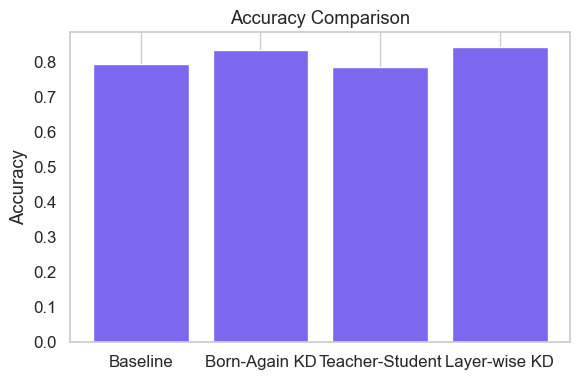

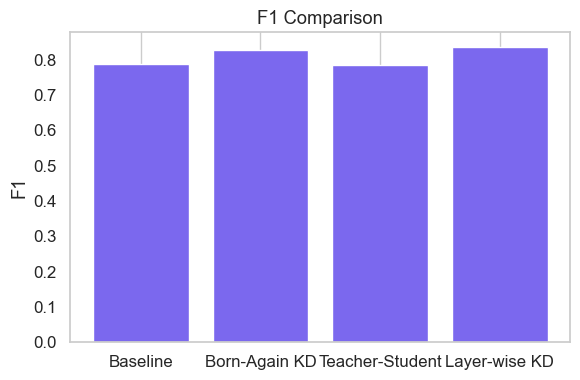

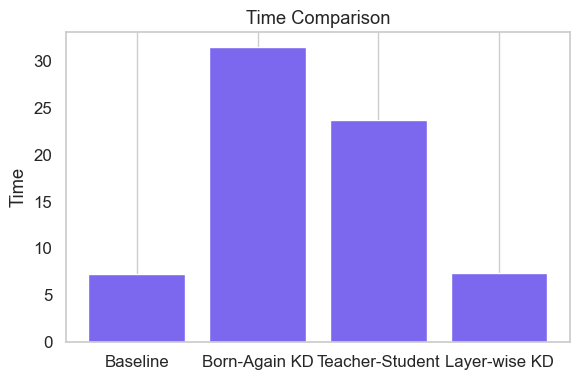

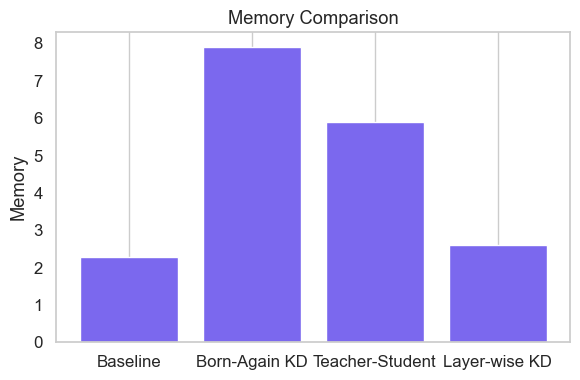

In [275]:

# Shared model builder
def create_model(input_size):
    inputs = Input(shape=(input_size,))
    x = Dense(64, activation='relu', name='layer1')(inputs)
    x = Dense(32, activation='relu', name='layer2')(x)
    output = Dense(4, activation='softmax')(x)
    return Model(inputs, output)

# Evaluate model
def evaluate(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    return acc, f1

# Baseline (no distillation)
def run_baseline(X_train, y_train, X_test, y_test, input_size):
    tracemalloc.start(); start = time.time()
    model = create_model(input_size)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)
    acc, f1 = evaluate(model, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Baseline", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}

# Born-Again (Iterative) Self-Distillation
def run_iterative_self_distillation(X_train, y_train, X_test, y_test, input_size, iterations=3):
    tracemalloc.start(); start = time.time()
    model = create_model(input_size)
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)
    for _ in range(iterations):
        soft_labels = model.predict(X_train)
        model.compile(optimizer=Adam(), loss=KLDivergence(), metrics=["accuracy"])
        model.fit(X_train, soft_labels, epochs=20, batch_size=64, verbose=0)
    acc, f1 = evaluate(model, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Born-Again KD", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}

# Intra-Model (Layer-Wise) Self-Distillation
def run_layerwise_self_distillation(X_train, y_train, X_test, y_test, input_size):
    # Manual tracking of teacher (h1) and student (h2)
    tracemalloc.start(); start = time.time()

    inputs = Input(shape=(input_size,))
    h1 = Dense(64, activation='relu', name='teacher_layer')(inputs)
    h2 = Dense(32, activation='relu', name='student_layer')(h1)
    output = Dense(4, activation='softmax')(h2)
    model = Model(inputs, output)

    # Custom training loop for layer-wise distillation
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

    acc, f1 = evaluate(model, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Layer-wise KD", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}

# Teacher-Student (Separate Models)
def run_teacher_student_kd(X_train, y_train, X_test, y_test, input_size):
    tracemalloc.start(); start = time.time()

    # Split into teacher and student datasets
    X_A, X_B, y_A, y_B = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

    teacher = create_model(input_size)
    teacher.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    teacher.fit(X_A, y_A, epochs=20, batch_size=64, verbose=0)
    soft_labels = teacher.predict(X_B)

    student = create_model(input_size)
    student.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    student.fit(X_B, y_B, epochs=20, batch_size=64, verbose=0)

    student.compile(optimizer=Adam(), loss=KLDivergence(), metrics=["accuracy"])
    student.fit(X_B, soft_labels, epochs=20, batch_size=64, verbose=0)

    acc, f1 = evaluate(student, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Teacher-Student", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}

def run_true_layerwise_distillation(X_train, y_train, X_test, y_test, input_size, alpha=0.5):
    tracemalloc.start(); start = time.time()

    # Define model with accessible intermediate outputs
    inputs = Input(shape=(input_size,))
    h1 = Dense(32, activation='relu', name='teacher_layer')(inputs)
    h2 = Dense(32, activation='relu', name='student_layer')(h1)
    output = Dense(4, activation='softmax')(h2)
    model = Model(inputs, output)

    # Extract intermediate outputs for loss
    teacher_model = Model(inputs, h1)
    student_model = Model(inputs, h2)

    # Custom loss function: CE + KL(teacher || student)
    def distillation_loss(y_true, y_pred):
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        t_out = teacher_model(X_train)
        s_out = student_model(X_train)
        kl_loss = tf.keras.losses.KLDivergence()(tf.stop_gradient(t_out), s_out)
        return ce_loss + alpha * kl_loss

    model.compile(optimizer=Adam(), loss=distillation_loss, metrics=["accuracy"])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

    acc, f1 = evaluate(model, X_test, y_test)
    end = time.time(); _, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
    return {"Method": "Layer-wise KD", "Accuracy": acc, "F1": f1, "Time": end - start, "Memory": peak / 1024**2}



input_size = X_train_small.shape[1]
results = [
    run_baseline(X_train_small, y_train_small, X_test_small, y_test_small, input_size),
    run_iterative_self_distillation(X_train_small, y_train_small, X_test_small, y_test_small, input_size),
    #run_layerwise_self_distillation(X_train_small, y_train_small, X_test_small, y_test_small, input_size),
    run_teacher_student_kd(X_train_small, y_train_small, X_test_small, y_test_small, input_size)
]
results.append(run_true_layerwise_distillation(X_train_small, y_train_small, X_test_small, y_test_small, input_size))

results_df = pd.DataFrame(results)
print(results_df)

# Visual Comparison
for metric in ["Accuracy", "F1", "Time", "Memory"]:
    plt.figure(figsize=(6, 4))
    plt.bar(results_df["Method"], results_df[metric], color='mediumslateblue')
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\2837673179.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=results_df, palette=colors)
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\2837673179.py:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x="Method", y=metric, data=results_df, palette=colors)


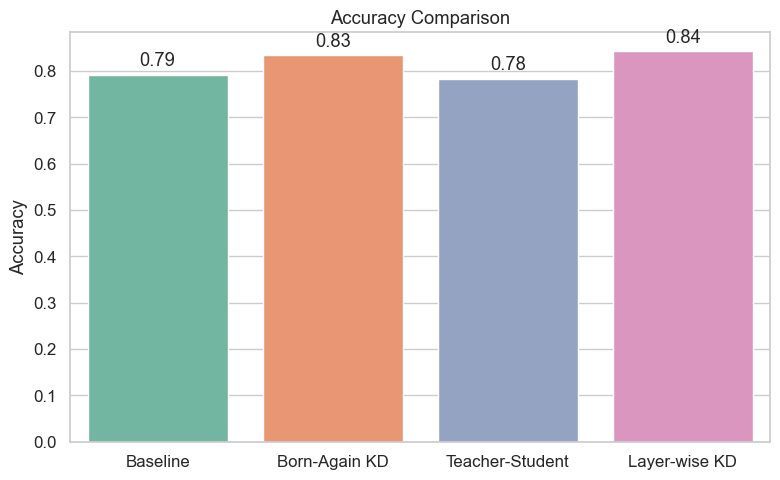

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\2837673179.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=results_df, palette=colors)
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\2837673179.py:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x="Method", y=metric, data=results_df, palette=colors)


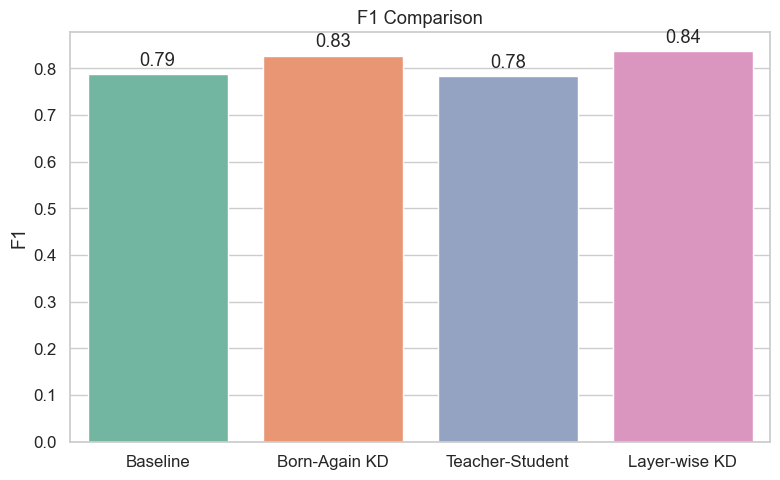

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\2837673179.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=results_df, palette=colors)
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\2837673179.py:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x="Method", y=metric, data=results_df, palette=colors)


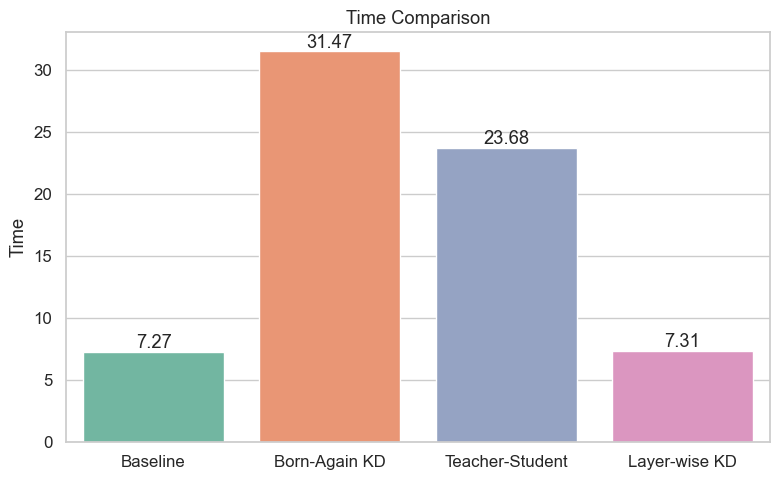

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\2837673179.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=results_df, palette=colors)
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\2837673179.py:10: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(x="Method", y=metric, data=results_df, palette=colors)


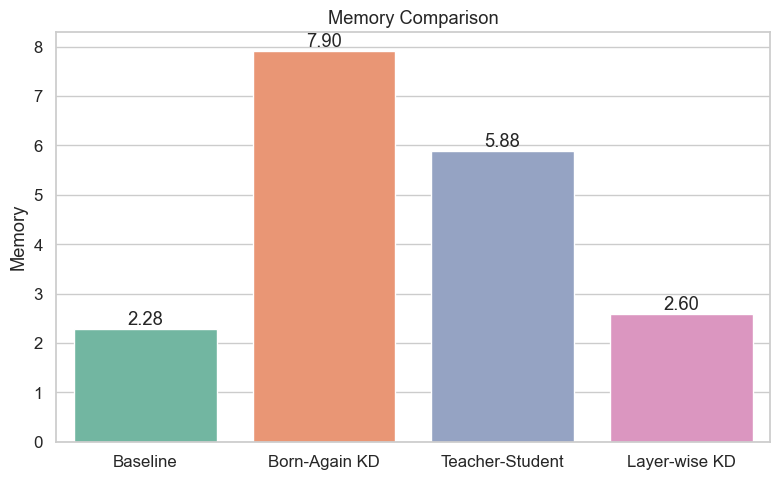

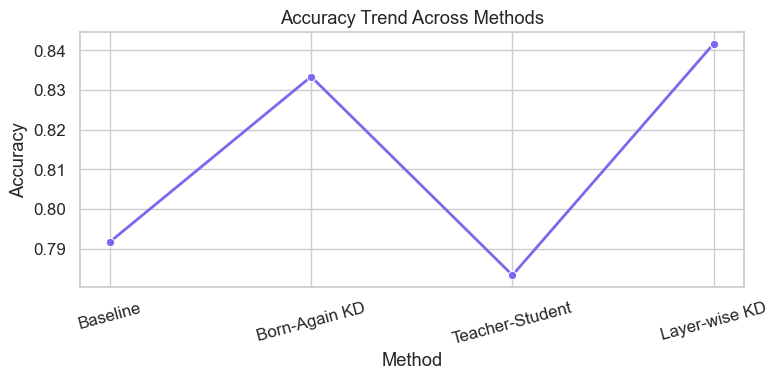

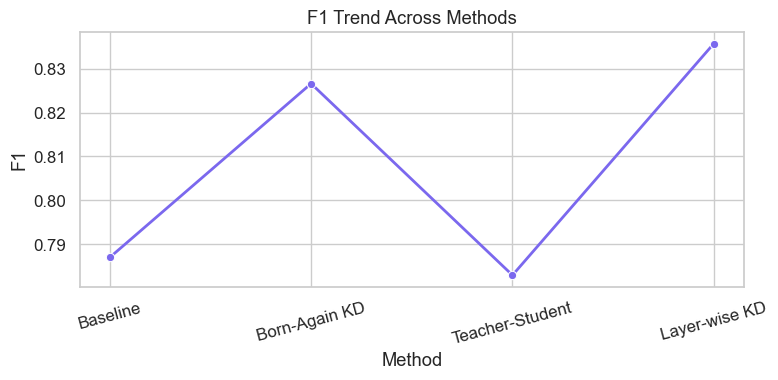

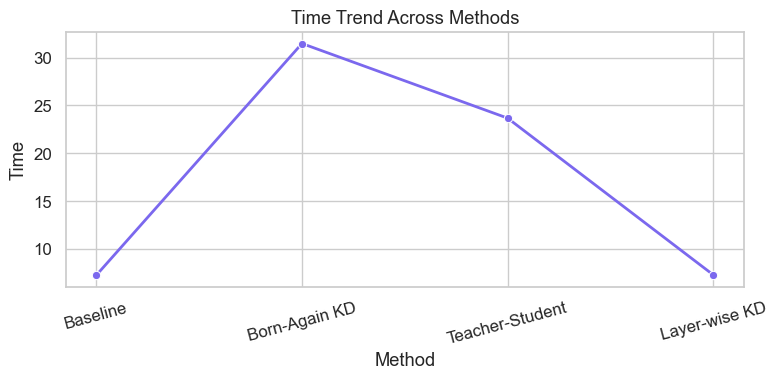

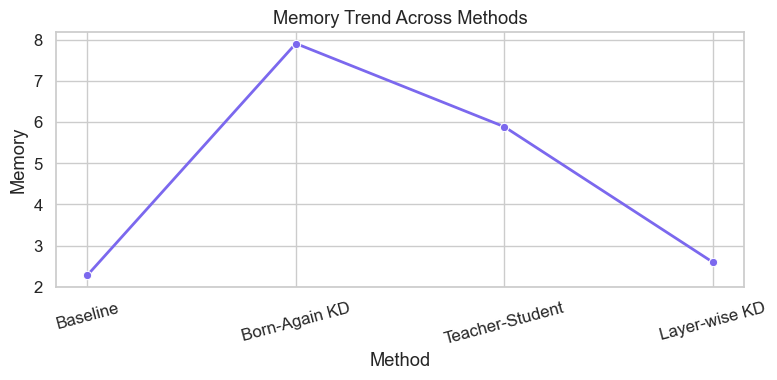

In [276]:

import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)
colors = sns.color_palette("Set2")

# BAR CHARTS 
metrics = ["Accuracy", "F1", "Time", "Memory"]
for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    sns.barplot(x="Method", y=metric, data=results_df, palette=colors)
    for index, row in results_df.iterrows():
        plt.text(index, row[metric] + 0.01, f"{row[metric]:.2f}", ha='center', va='bottom')
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xlabel("")
    plt.tight_layout()
    plt.show()


# LINE PLOT 
for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.lineplot(x="Method", y=metric, data=results_df, marker='o', linewidth=2, color="mediumslateblue")
    plt.title(f"{metric} Trend Across Methods")
    plt.ylabel(metric)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

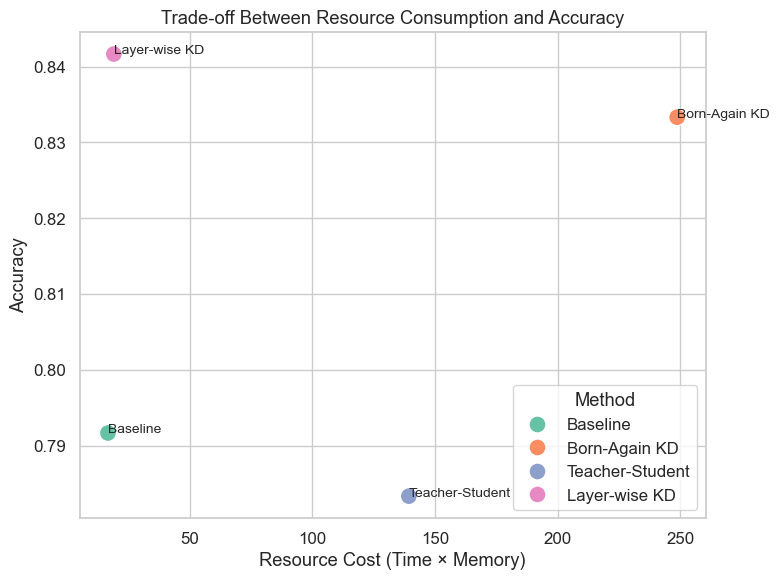

In [277]:
results_df["Complexity"] = results_df["Time"] * results_df["Memory"]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="Complexity", y="Accuracy", data=results_df, hue="Method", s=150, palette="Set2")

for i in range(len(results_df)):
    plt.text(results_df["Complexity"][i] + 0.1, results_df["Accuracy"][i], results_df["Method"][i], fontsize=10)

plt.title("Trade-off Between Resource Consumption and Accuracy")
plt.xlabel("Resource Cost (Time × Memory)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

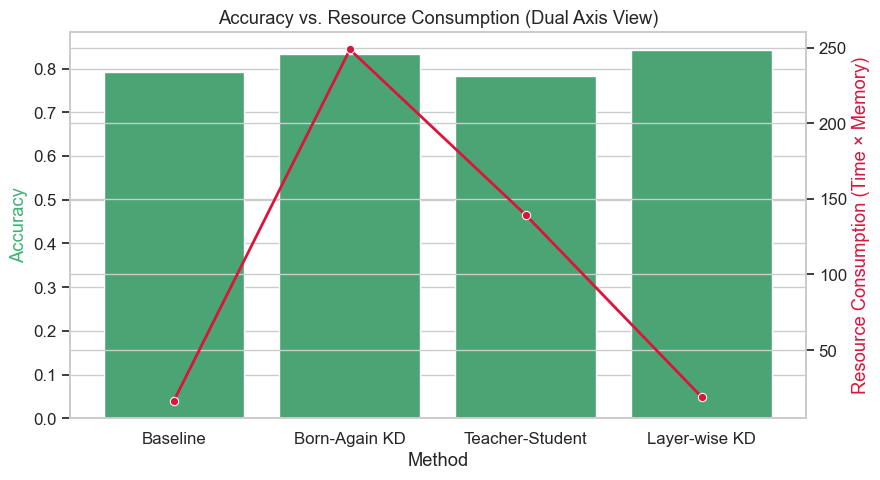

In [279]:
fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()

sns.barplot(x="Method", y="Accuracy", data=results_df, ax=ax1, color="mediumseagreen")
sns.lineplot(x="Method", y="Complexity", data=results_df, ax=ax2, color="crimson", marker="o", linewidth=2)

ax1.set_ylabel("Accuracy", color="mediumseagreen")
ax2.set_ylabel("Resource Consumption (Time × Memory)", color="crimson")
ax1.set_title("Accuracy vs. Resource Consumption (Dual Axis View)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [280]:

results_df

,Method,Accuracy,F1,Time,Memory,Complexity
0,Baseline,0.791667,0.786974,7.274301,2.280499,16.589033
1,Born-Again KD,0.833333,0.826612,31.467745,7.903461,248.704112
2,Teacher-Student,0.783333,0.782939,23.675935,5.883427,139.295629
3,Layer-wise KD,0.841667,0.835751,7.311929,2.595856,18.980713


In [281]:
class_counts = df['Room_Occupancy_Count'].value_counts()

# Determine the number of samples in the minority class
min_class_count = class_counts.min()

# Create an undersampled dataset
undersampled_data = df.groupby('Room_Occupancy_Count').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

# Separate features and labels
X_resampled = undersampled_data.drop('Room_Occupancy_Count', axis=1)
y_resampled = undersampled_data['Room_Occupancy_Count']

# Calculate the size of the DataFrame in bytes
df_size_bytes = undersampled_data.memory_usage(deep=True).sum()

# Convert to megabytes
df_size_mb = df_size_bytes / (1024 ** 2)
print(f"DataFrame size: {df_size_mb:.2f} MB")
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


DataFrame size: 0.27 MB


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\513774212.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_data = df.groupby('Room_Occupancy_Count').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)


In [41]:

'''
Self - distillation within the same model, where knowledge is distilled from deeper layers to the shallower layers of a single model


'''
def fog_model(X_train, y_train):
    input_size = X_train.shape[1]
   
    inputs = Input(shape=(input_size,))
    
    x = Dense(64, activation='relu')(inputs)
    teacher_logits = Dense(4, activation=None, name="teacher_logits")(x)  # No activation (raw logits)
    x = Dense(32, activation='relu')(teacher_logits)  # Student gets teacher's soft logits
    student_output = Dense(4, activation='softmax', name="student_output")(x)  
    model = Model(inputs=inputs, outputs=student_output)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # Use sparse if labels are integers
        metrics=["accuracy"]
    )
   
    tracemalloc.start()
    start_time = time.time()
   
    model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

    end_time = time.time()
    current_memory, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    total_time_modeltrain = end_time - start_time

    start_time = time.time()
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    end_time = time.time()
    total_time_modeltest = end_time - start_time

    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Time Taken for Model Training: {total_time_modeltrain:.2f} seconds")
    print(f"Time Taken for Model Testing: {total_time_modeltest:.2f} seconds")
    print(f"Peak Memory Used: {peak_memory / 1024**2:.2f} MB")

    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1) 

    print(classification_report(y_test, y_pred_classes))
    f1 = f1_score(y_test, y_pred_classes, average="macro")
    print("Macro F1 Score: ", f1)

    print(confusion_matrix(y_test, y_pred_classes))
    
    return model

# Train the model
fog_model = fog_model(X_train, y_train)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7589 - loss: 2.6080 - val_accuracy: 0.9550 - val_loss: 0.2057
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9677 - loss: 0.1768 - val_accuracy: 0.9556 - val_loss: 0.1607
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9699 - loss: 0.1296 - val_accuracy: 0.9729 - val_loss: 0.0924
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.1163 - val_accuracy: 0.9772 - val_loss: 0.0630
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9766 - loss: 0.0688 - val_accuracy: 0.9827 - val_loss: 0.0480
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9797 - loss: 0.0606 - val_accuracy: 0.9698 - val_loss: 0.0810
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9781 - loss: 0.0612 - val_accuracy: 0.9827 - val_loss: 0.0454
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9844 - loss: 0.0599 - val_accu

In [39]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [73]:
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text


X_train_np = np.array(X_train)

sample_size = min(200, X_train_np.shape[0])  
sample_X_train = X_train_np[:sample_size]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(fog_model, sample_X_train)

shap_values = explainer.shap_values(X_train_np)[0]  # Getting the first output
shap_values1 = explainer.shap_values(X_train_np)[1]
shap_values2 = explainer.shap_values(X_train_np)[2]
shap_values3 = explainer.shap_values(X_train_np)[3]

# Compute mean absolute SHAP values for feature ranking
feature_importance = np.abs(shap_values).mean(axis=0)

# Select top-k important features
k = 10
top_features = np.argsort(feature_importance)[-k:][::-1]
selected_X_train = X_train_np[:, top_features]

# Train a simple Decision Tree to approximate the neural network
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(selected_X_train, y_train)

# Extract IF-THEN rules from the decision tree
rules= export_text(tree_clf, feature_names=df.columns[top_features].tolist())

print("Extracted Rules for Edge Execution:")
print(rules)


C:\Users\Administrator\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_221
Received: inputs=['Tensor(shape=(200, 19))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_221
Received: inputs=['Tensor(shape=(400, 19))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_221
Receive

Extracted Rules for Edge Execution:
|--- S2_Temp <= 25.72
|   |--- S2_Temp <= 24.97
|   |   |--- class: 1.0
|   |--- S2_Temp >  24.97
|   |   |--- S1_Temp <= 25.72
|   |   |   |--- S1_Temp <= 25.47
|   |   |   |   |--- class: 0.0
|   |   |   |--- S1_Temp >  25.47
|   |   |   |   |--- class: 0.0
|   |   |--- S1_Temp >  25.72
|   |   |   |--- S3_Temp <= 25.28
|   |   |   |   |--- class: 2.0
|   |   |   |--- S3_Temp >  25.28
|   |   |   |   |--- class: 0.0
|--- S2_Temp >  25.72
|   |--- S1_Temp <= 26.09
|   |   |--- S4_Temp <= 26.22
|   |   |   |--- S2_Temp <= 26.03
|   |   |   |   |--- class: 0.0
|   |   |   |--- S2_Temp >  26.03
|   |   |   |   |--- class: 3.0
|   |   |--- S4_Temp >  26.22
|   |   |   |--- S3_Temp <= 25.47
|   |   |   |   |--- class: 2.0
|   |   |   |--- S3_Temp >  25.47
|   |   |   |   |--- class: 0.0
|   |--- S1_Temp >  26.09
|   |   |--- S2_Temp <= 25.91
|   |   |   |--- S3_Temp <= 25.84
|   |   |   |   |--- class: 2.0
|   |   |   |--- S3_Temp >  25.84
|   |   |   | 

In [282]:
shap_values_all = explainer.shap_values(X_train_np)

C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_221
Received: inputs=['Tensor(shape=(8103, 19))']
  warnings.warn(msg)


In [210]:
# Print
for class_idx in range(num_classes):
    print(f"\nRules for Occupancy Class {class_idx}:")
    print(rules[class_idx])


Rules for Occupancy Class 0:
|--- S1_Light <= 92.00
|   |--- S5_CO2_Slope <= 0.46
|   |   |--- S7_PIR <= 0.50
|   |   |   |--- S5_CO2_Slope <= 0.19
|   |   |   |   |--- class: 0
|   |   |   |--- S5_CO2_Slope >  0.19
|   |   |   |   |--- class: 0
|   |   |--- S7_PIR >  0.50
|   |   |   |--- S5_CO2_Slope <= -0.15
|   |   |   |   |--- class: 0
|   |   |   |--- S5_CO2_Slope >  -0.15
|   |   |   |   |--- class: 3
|   |--- S5_CO2_Slope >  0.46
|   |   |--- Day_of_Week <= 3.00
|   |   |   |--- S2_Light <= 1.00
|   |   |   |   |--- class: 0
|   |   |   |--- S2_Light >  1.00
|   |   |   |   |--- class: 3
|   |   |--- Day_of_Week >  3.00
|   |   |   |--- S5_CO2 <= 1260.00
|   |   |   |   |--- class: 0
|   |   |   |--- S5_CO2 >  1260.00
|   |   |   |   |--- class: 3
|--- S1_Light >  92.00
|   |--- S3_Light <= 71.50
|   |   |--- S2_Light <= 113.00
|   |   |   |--- class: 1
|   |   |--- S2_Light >  113.00
|   |   |   |--- class: 2
|   |--- S3_Light >  71.50
|   |   |--- S5_CO2 <= 757.50
|   |   | 

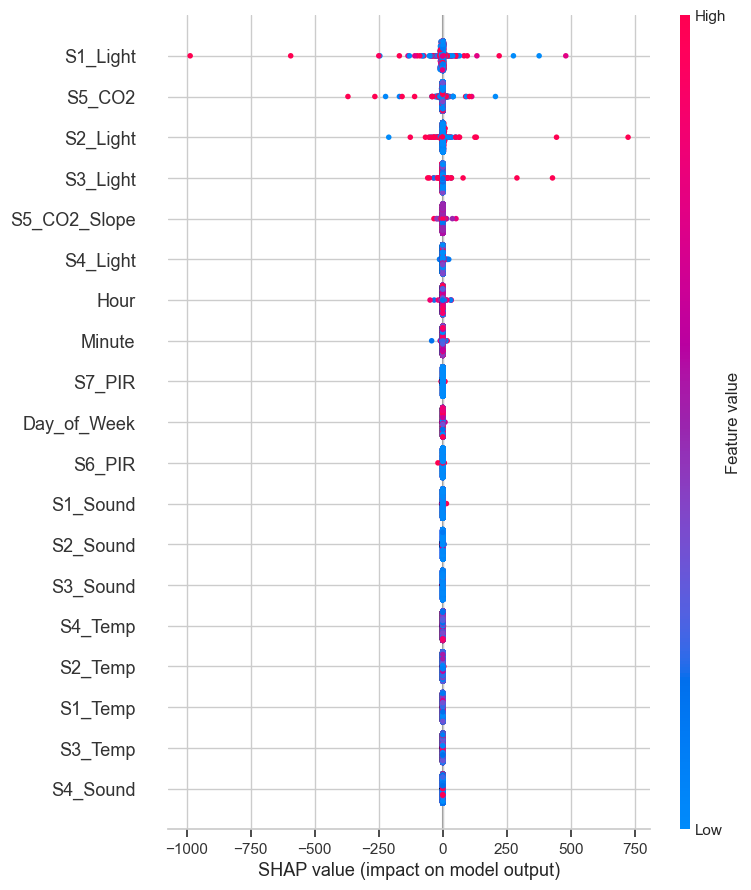

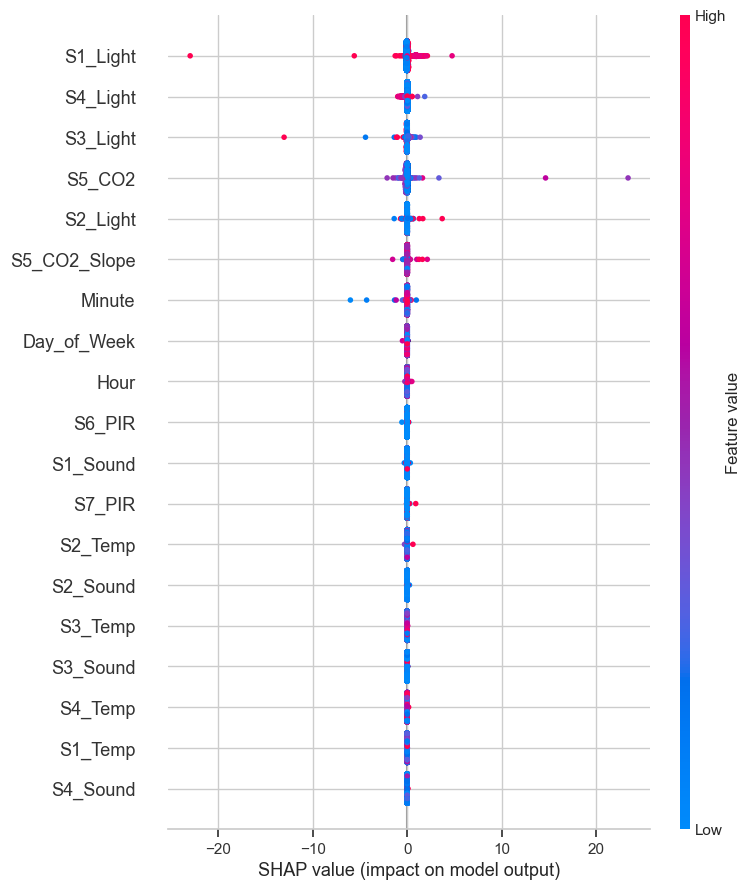

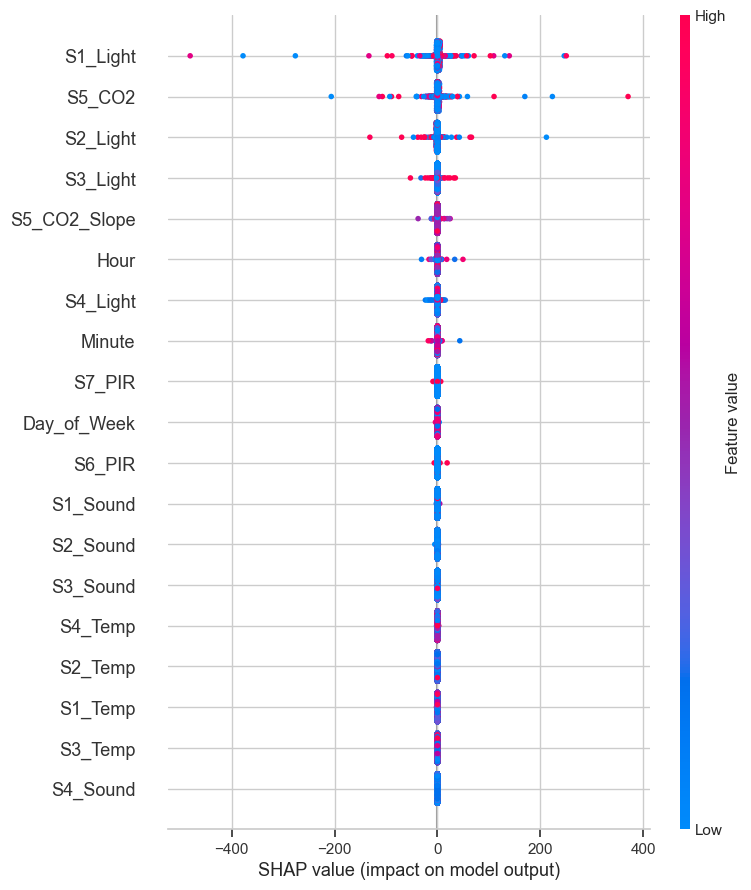

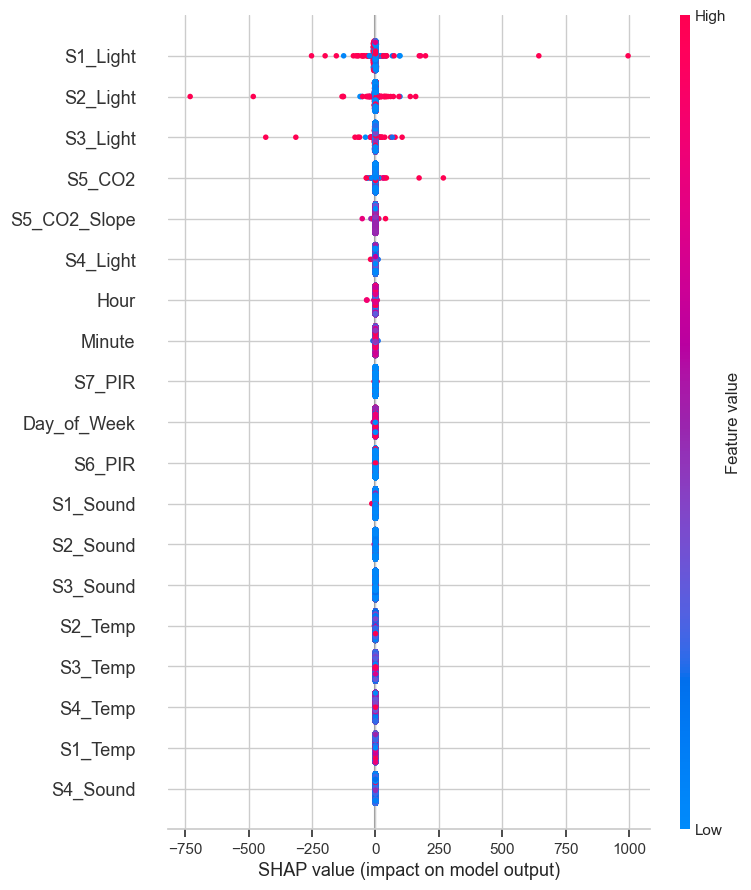

In [82]:
for i in range(4):
    shap.summary_plot(
        shap_values_all[:, :, i],
        X_train_np,
        feature_names=df.drop(columns=["Room_Occupancy_Count"]).columns,
        plot_type="dot",
        class_names=[str(i)]
    )

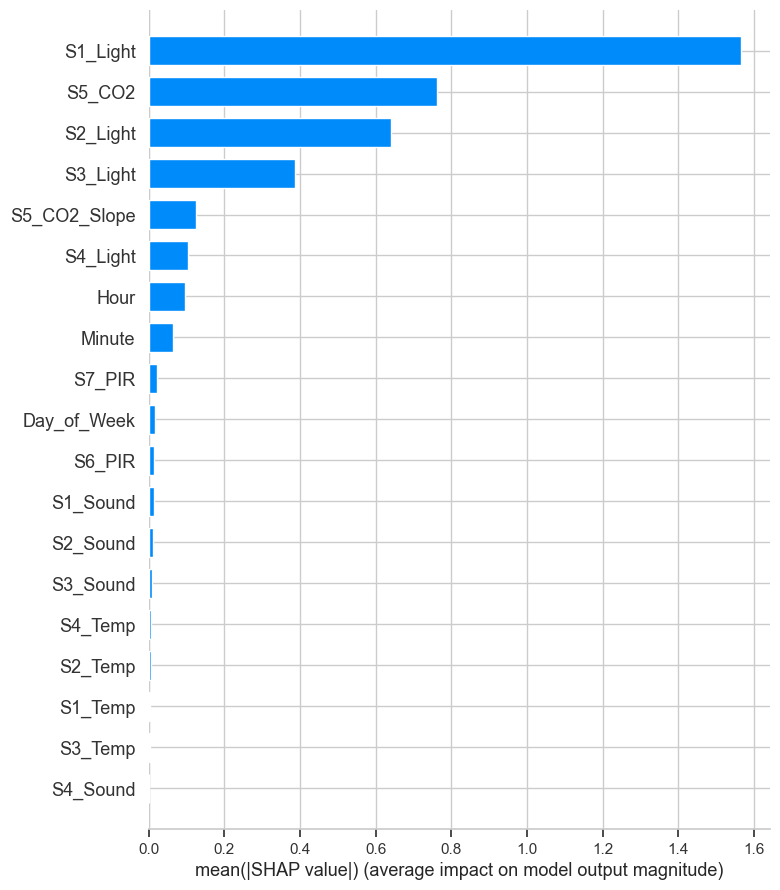

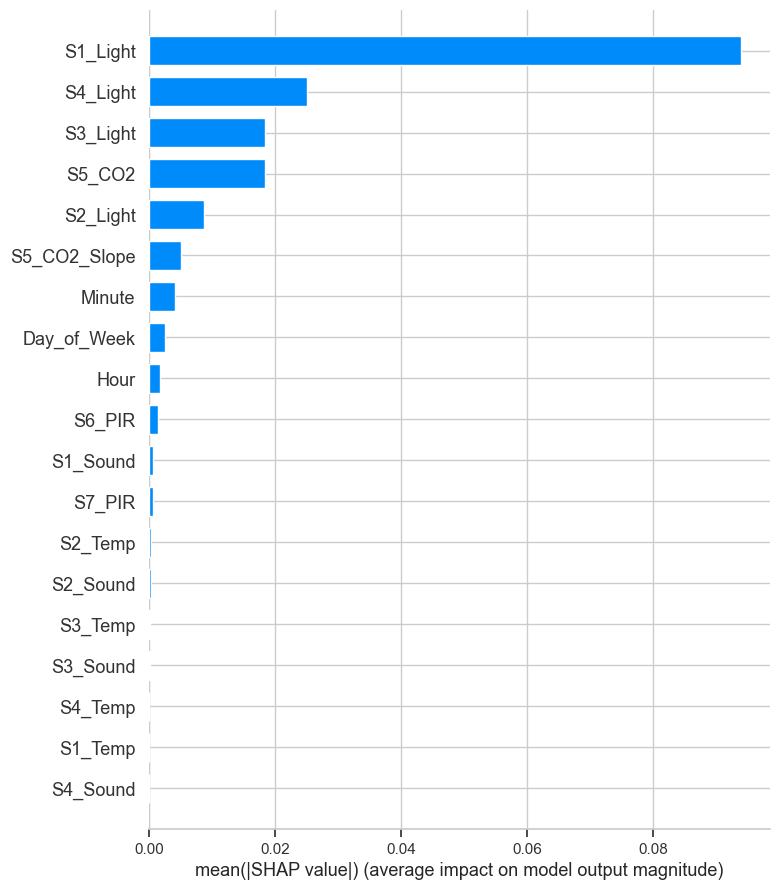

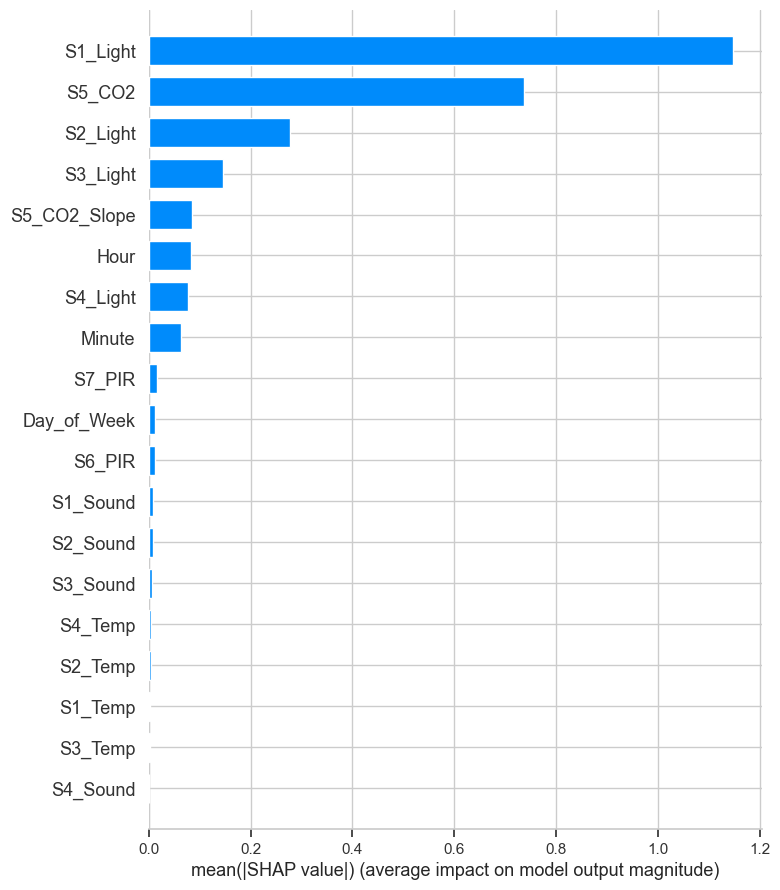

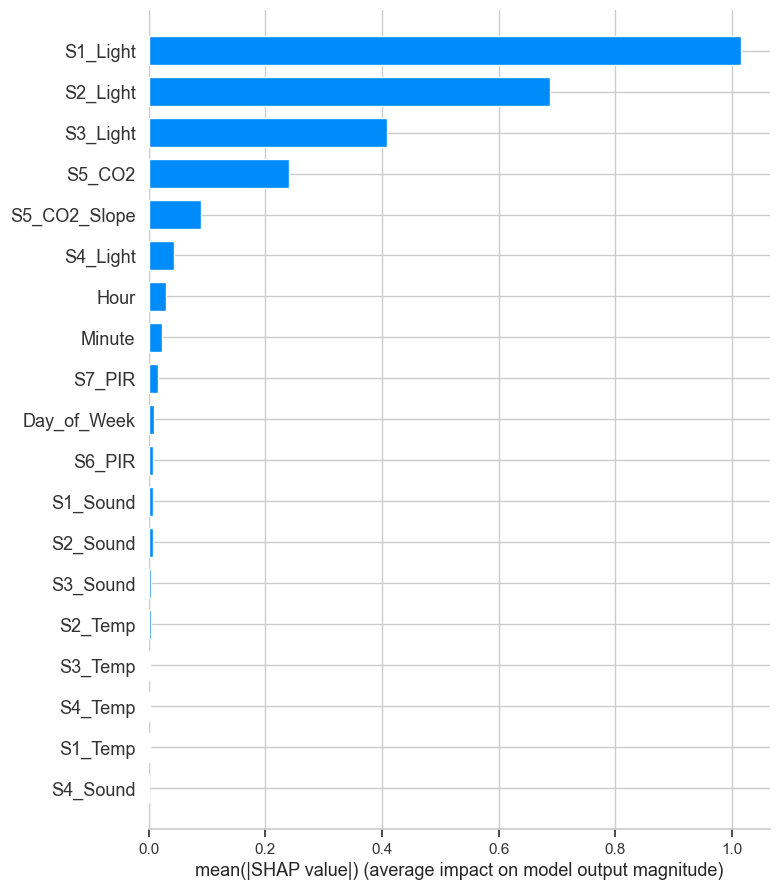

In [92]:
shap_values_class0 = shap_values_all[:, :, 0]
shap_values_class1 = shap_values_all[:, :, 1]
shap_values_class2 = shap_values_all[:, :, 2]
shap_values_class3 = shap_values_all[:, :, 3]
shap.summary_plot(
    shap_values_class0,
    X_train_np,
    feature_names=df.drop(columns=["Room_Occupancy_Count"]).columns.tolist(),
    plot_type="bar"
)
shap.summary_plot(
    shap_values_class1,
    X_train_np,
    feature_names=df.drop(columns=["Room_Occupancy_Count"]).columns.tolist(),
    plot_type="bar"
)
shap.summary_plot(
    shap_values_class2,
    X_train_np,
    feature_names=df.drop(columns=["Room_Occupancy_Count"]).columns.tolist(),
    plot_type="bar"
)
shap.summary_plot(
    shap_values_class3,
    X_train_np,
    feature_names=df.drop(columns=["Room_Occupancy_Count"]).columns.tolist(),
    plot_type="bar"
)

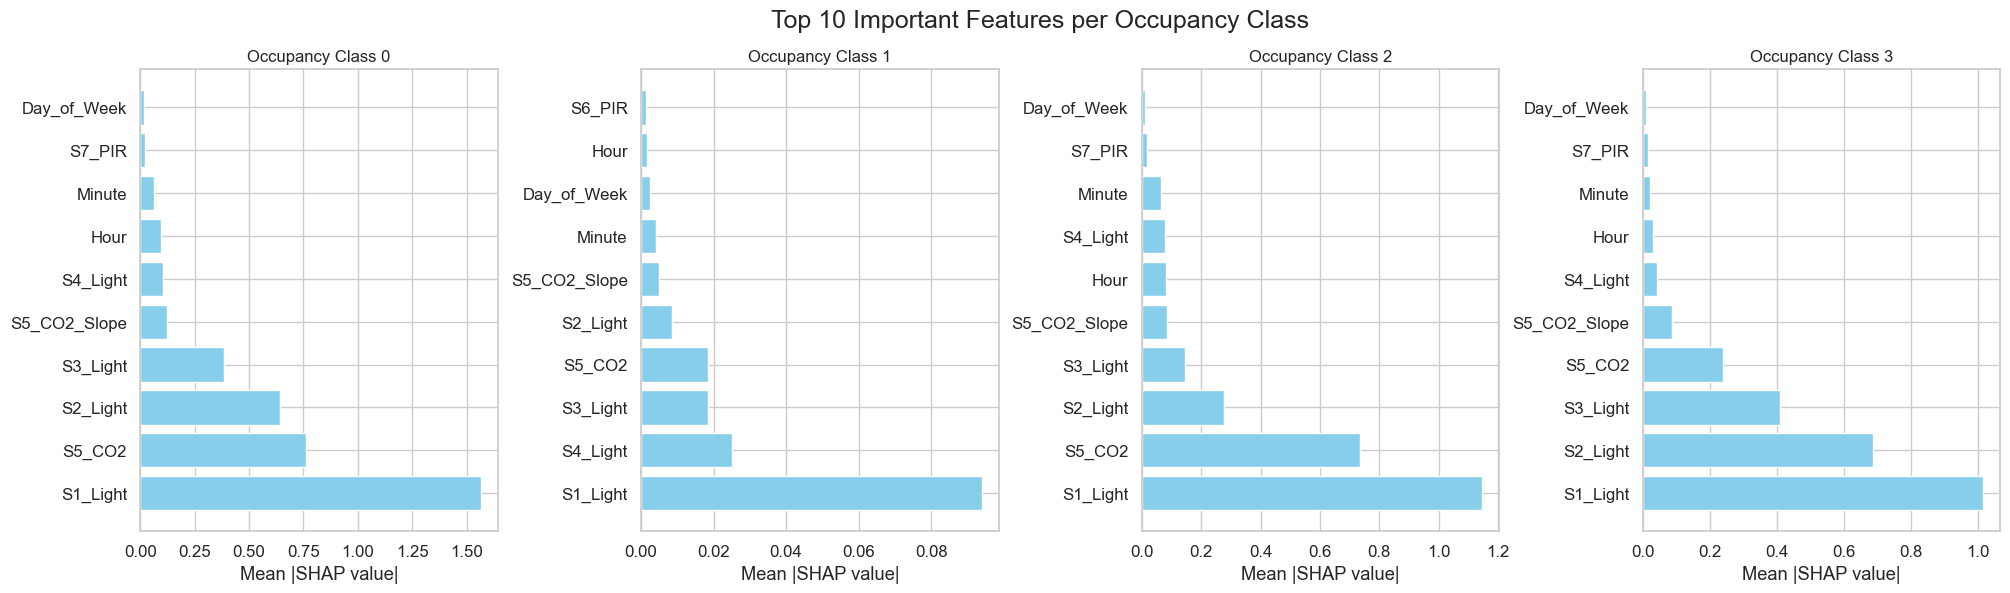

In [97]:

# Feature names
feature_names = df.drop(columns=["Room_Occupancy_Count"]).columns.tolist()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
plt.subplots_adjust(wspace=0.4)

for class_idx in range(4):
    shap_values_class = shap_values_all[:, :, class_idx]
    mean_abs_shap = np.abs(shap_values_class).mean(axis=0)
    top_k = 10
    top_indices = np.argsort(mean_abs_shap)[-top_k:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_shap_vals = mean_abs_shap[top_indices]

    axes[class_idx].barh(top_features[::-1], top_shap_vals[::-1], color="skyblue")
    axes[class_idx].set_title(f"Occupancy Class {class_idx}", fontsize=12)
    axes[class_idx].set_xlabel("Mean |SHAP value|")
    axes[class_idx].invert_yaxis()

plt.suptitle("Top 10 Important Features per Occupancy Class", fontsize=18)

plt.savefig("shap_summary_class.png", bbox_inches="tight")
plt.show()

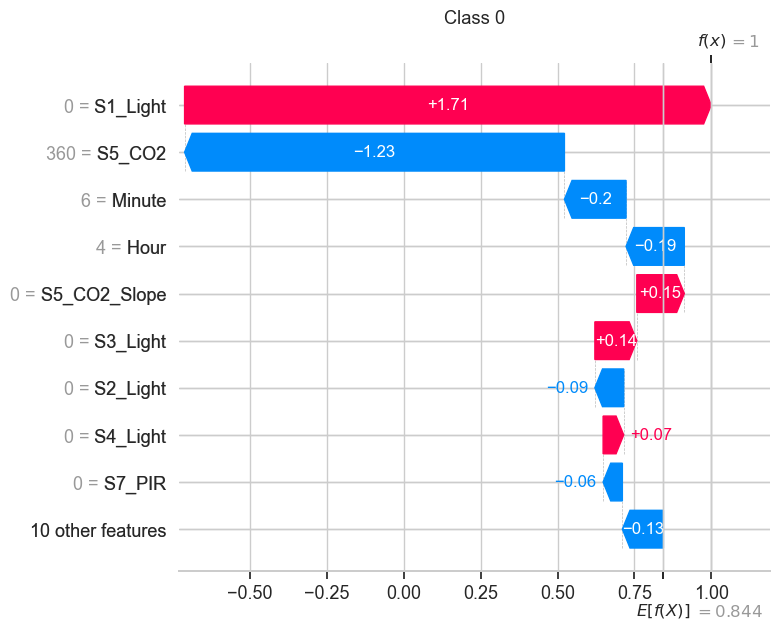

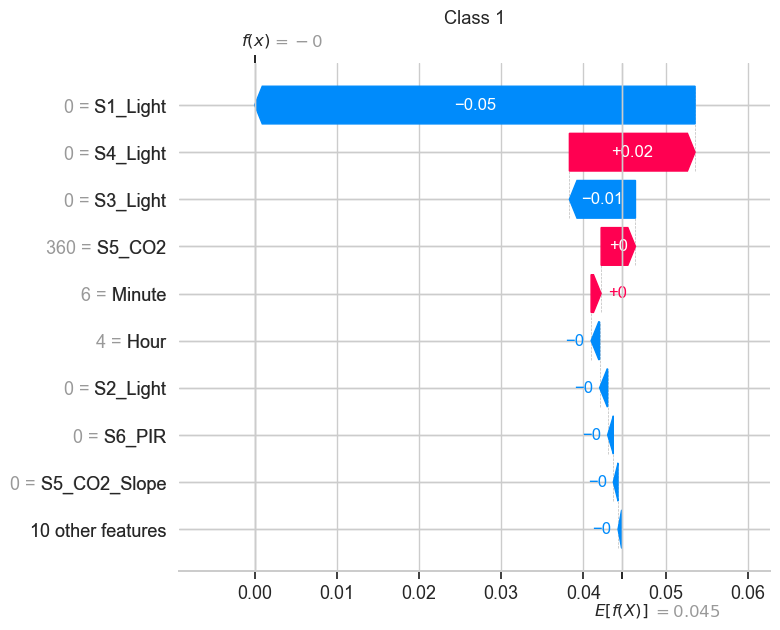

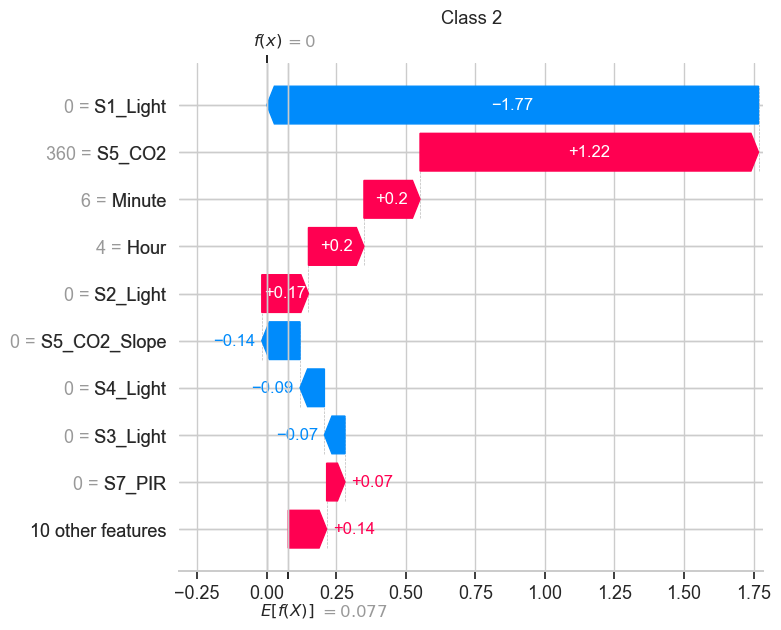

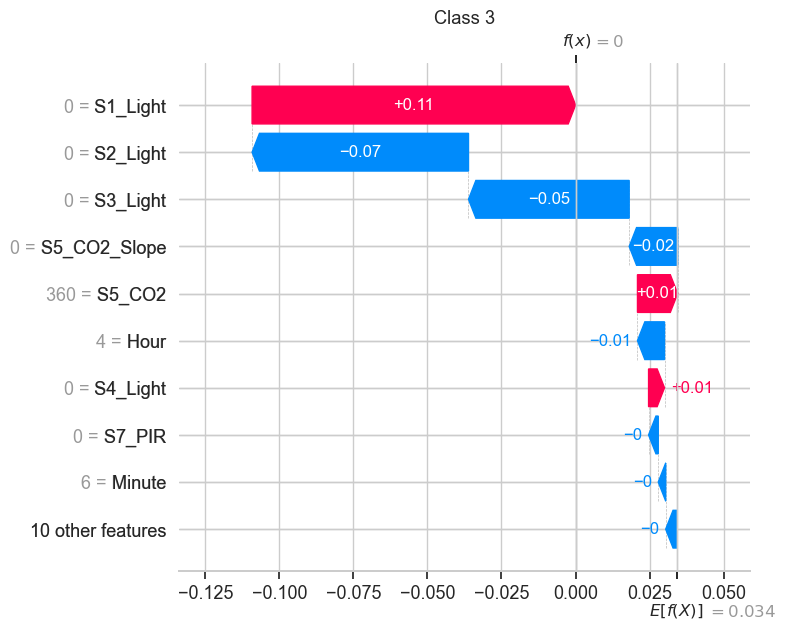

In [108]:
import os

instance_idx = 0 
output_dir = "shap_waterfall_plots"
os.makedirs(output_dir, exist_ok=True)

expected_values = [
    val.numpy().item() if hasattr(val, "numpy") else val
    for val in explainer.expected_value
]

for class_idx in range(4):
    explanation = shap.Explanation(
        values=shap_values_all[instance_idx, :, class_idx],
        base_values=expected_values[class_idx],
        data=X_train_np[instance_idx],
        feature_names=feature_names
    )
    
    # Plot and save
    plt.figure()
    shap.plots.waterfall(explanation, show=False)
    plt.title(f"Class {class_idx}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/waterfall_class_{class_idx}.png", dpi=300)
    plt.show()


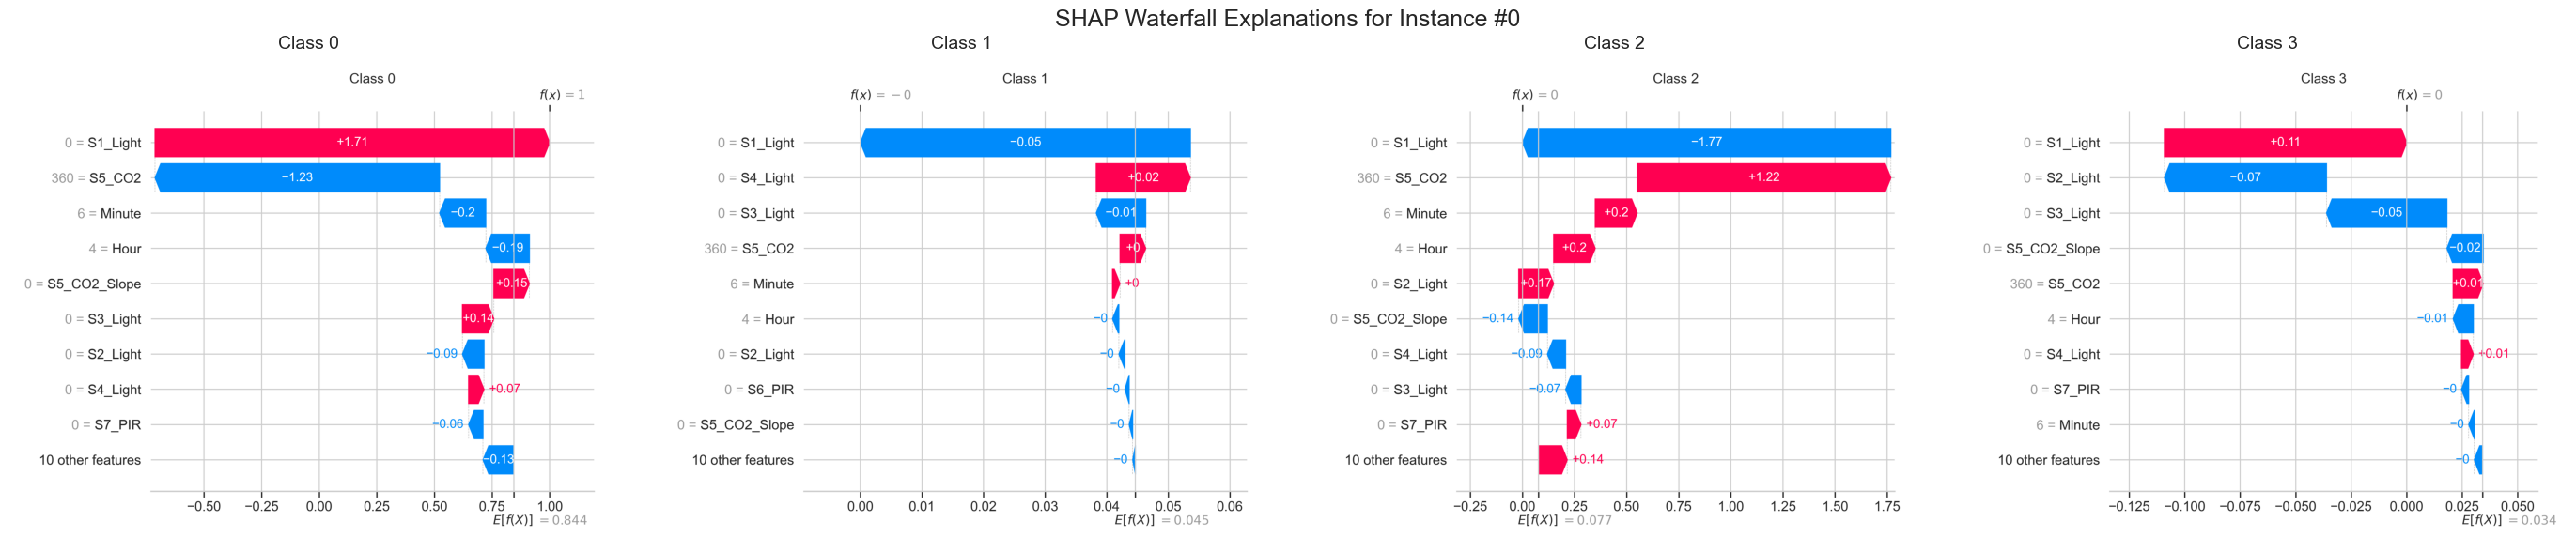

In [110]:
fig, axes = plt.subplots(1, 4, figsize=(28, 6))

for i in range(4):
    img = plt.imread(f"{output_dir}/waterfall_class_{i}.png")
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Class {i}", fontsize=14)

plt.suptitle(f"SHAP Waterfall Explanations for Instance #{instance_idx}", fontsize=18)
plt.tight_layout()
plt.show()

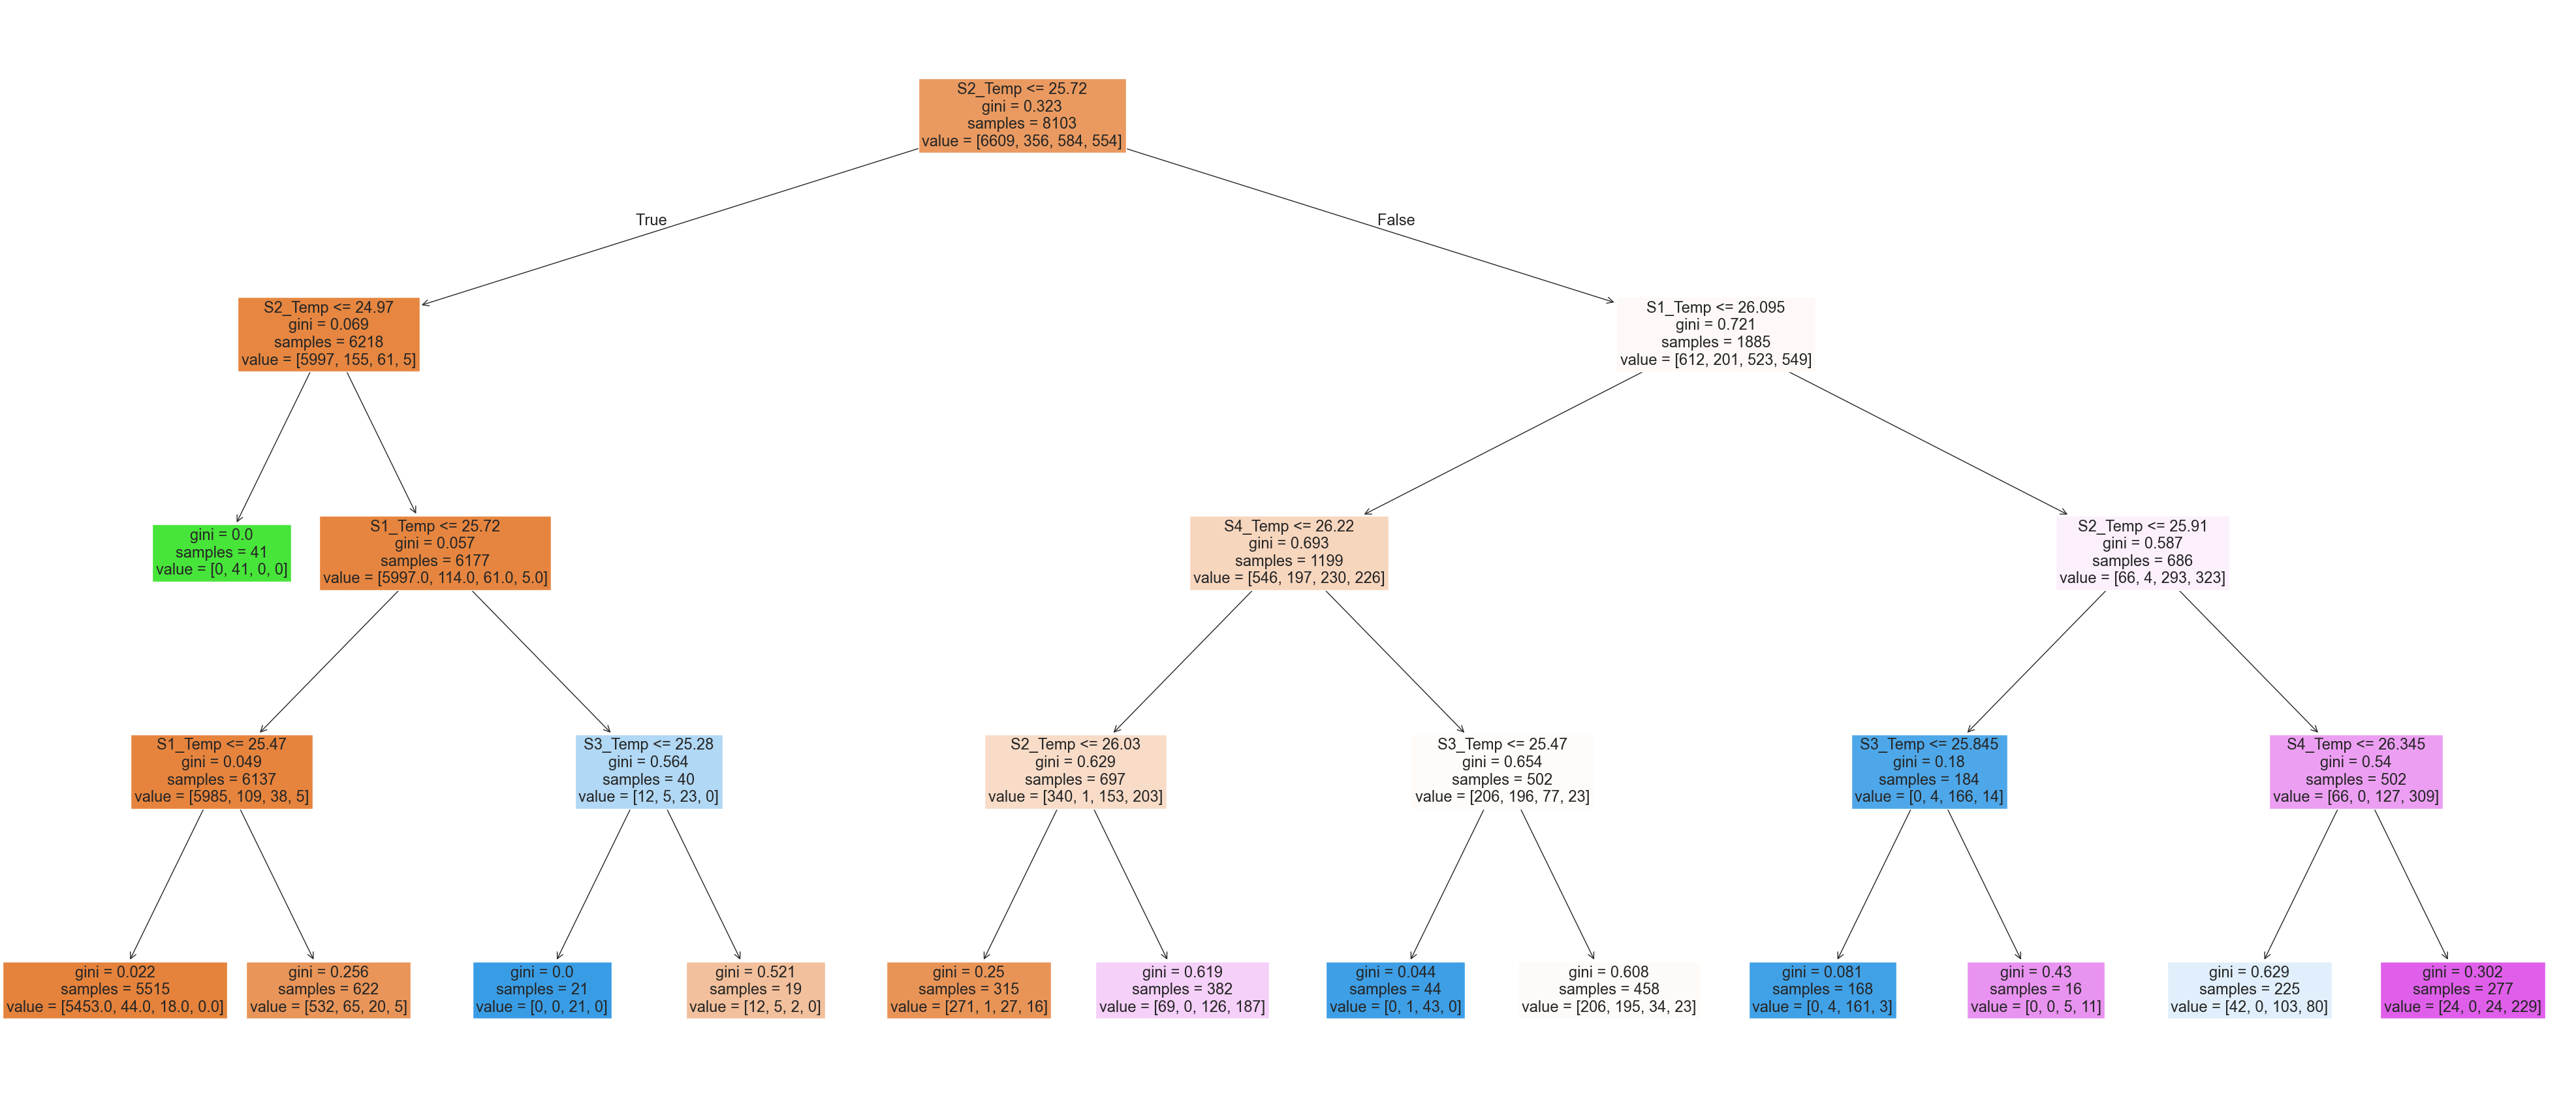

In [113]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(40, 18))
plot_tree(tree_clf, 
          feature_names=df.columns[top_features].tolist(), 
          filled=True, 
          rounded=False, 
          fontsize=17,
          ax=ax)

plt.tight_layout()
plt.subplots_adjust(bottom=0.05, top=0.98)


plt.savefig("decision_tree.png", dpi=300)
plt.show()

C:\Users\Administrator\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_221
Received: inputs=['Tensor(shape=(400, 19))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_221
Received: inputs=['Tensor(shape=(800, 19))']
  warnings.warn(msg)
C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_221
Receive

Extracted Rules for Edge Execution:
|--- S2_Temp <= 25.72
|   |--- S2_Temp <= 24.97
|   |   |--- class: 1.0
|   |--- S2_Temp >  24.97
|   |   |--- S1_Temp <= 25.72
|   |   |   |--- S1_Temp <= 25.47
|   |   |   |   |--- class: 0.0
|   |   |   |--- S1_Temp >  25.47
|   |   |   |   |--- class: 0.0
|   |   |--- S1_Temp >  25.72
|   |   |   |--- S3_Temp <= 25.28
|   |   |   |   |--- class: 2.0
|   |   |   |--- S3_Temp >  25.28
|   |   |   |   |--- class: 0.0
|--- S2_Temp >  25.72
|   |--- S1_Temp <= 26.09
|   |   |--- S4_Temp <= 26.22
|   |   |   |--- S2_Temp <= 26.03
|   |   |   |   |--- class: 0.0
|   |   |   |--- S2_Temp >  26.03
|   |   |   |   |--- class: 3.0
|   |   |--- S4_Temp >  26.22
|   |   |   |--- S3_Temp <= 25.47
|   |   |   |   |--- class: 2.0
|   |   |   |--- S3_Temp >  25.47
|   |   |   |   |--- class: 0.0
|   |--- S1_Temp >  26.09
|   |   |--- S2_Temp <= 25.91
|   |   |   |--- S3_Temp <= 25.84
|   |   |   |   |--- class: 2.0
|   |   |   |--- S3_Temp >  25.84
|   |   |   | 

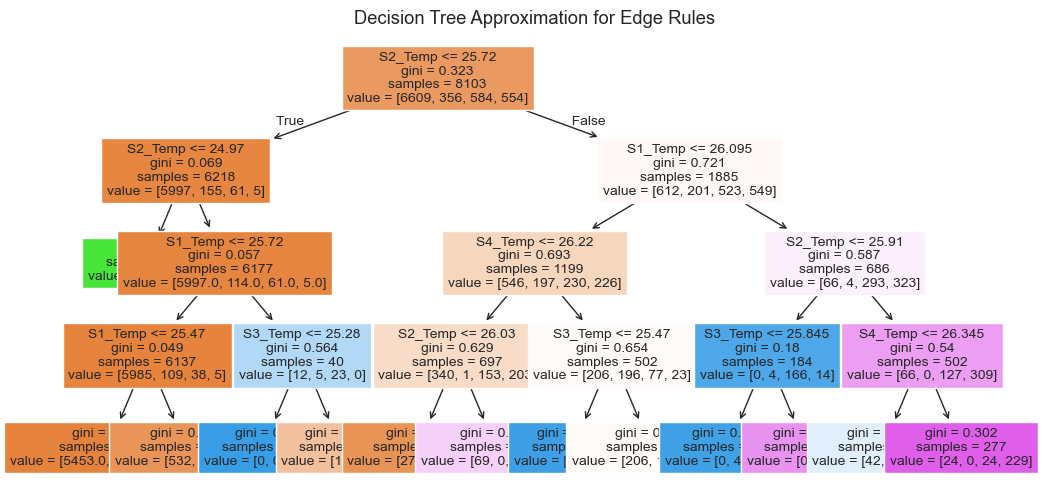

In [151]:

X_train_np = np.array(X_train)

sample_size = min(400, X_train_np.shape[0])  
sample_X_train = X_train_np[:sample_size]

explainer = shap.DeepExplainer(fog_model, sample_X_train)
shap_values = explainer.shap_values(X_train_np)[0]  # For class 0

feature_importance = np.abs(shap_values).mean(axis=0)

k = 10
top_features = np.argsort(feature_importance)[-k:][::-1]
top_feature_names = df.columns[top_features].tolist()
selected_X_train = X_train_np[:, top_features]

tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(selected_X_train, y_train)

# Extract rules
rules = export_text(tree_clf, feature_names=top_feature_names)

print("Extracted Rules for Edge Execution:")
print(rules)

from sklearn.tree import plot_tree

plt.figure(figsize=(12, 6))
plot_tree(tree_clf, feature_names=top_feature_names, filled=True, fontsize=10)
plt.title("Decision Tree Approximation for Edge Rules")
plt.show()

In [215]:
from sklearn.tree import _tree

def generate_python_rule_function(tree_model, feature_names, function_name="edge_decision"):
    tree_ = tree_model.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            return (
                f"{indent}if input['{name}'] <= {threshold:.4f}:\n"
                + recurse(tree_.children_left[node], depth + 1)
                + f"{indent}else:\n"
                + recurse(tree_.children_right[node], depth + 1)
            )
        else:
            pred_class = np.argmax(tree_.value[node])
            return f"{indent}return {pred_class}\n"

    code = f"def {function_name}(input):\n" + recurse(0, 1)
    return code

# Generate Python code from tree model
edge_code = generate_python_rule_function(tree_clf, top_feature_names)

print(edge_code)

# Execute code
exec(edge_code)


def edge_decision(input):
    if input['S1_Light'] <= 92.0000:
        if input['S5_CO2_Slope'] <= 0.4558:
            if input['S7_PIR'] <= 0.5000:
                if input['S5_CO2_Slope'] <= 0.1904:
                    return 0
                else:
                    return 0
            else:
                if input['S5_CO2_Slope'] <= -0.1519:
                    return 0
                else:
                    return 3
        else:
            if input['Day_of_Week'] <= 3.0000:
                if input['S2_Light'] <= 1.0000:
                    return 0
                else:
                    return 3
            else:
                if input['S5_CO2'] <= 1260.0000:
                    return 0
                else:
                    return 3
    else:
        if input['S3_Light'] <= 71.5000:
            if input['S2_Light'] <= 113.0000:
                return 1
            else:
                return 2
        else:
            if input['S5_CO2'] <= 757.5000:
         

In [216]:
import random
n_samples = 10
random_indices = random.sample(range(len(X_test)), n_samples)
correct = 0
print("Sample Predictions (Edge Rule Evaluation):\n")
for i in random_indices:
    row = X_test.iloc[i] if isinstance(X_test, pd.DataFrame) else X_test[i]
    label = y_test.iloc[i] if isinstance(y_test, pd.Series) else y_test[i]
    input_dict = dict(zip(top_feature_names, row[top_features]))
    print(input_dict)

    prediction = edge_decision(input_dict)
    print(f"Sample {i} | True: {label}, Predicted: {prediction}")

    if prediction == label:
        correct += 1

print(f"\nAccuracy on {n_samples} random samples: {correct}/{n_samples} = {correct / n_samples:.2f}")

Sample Predictions (Edge Rule Evaluation):

{'S1_Light': 149.0, 'S2_Light': 236.0, 'S3_Light': 179.0, 'S5_CO2': 885.0, 'S5_CO2_Slope': 2.56538461538, 'S4_Light': 11.0, 'Hour': 17.0, 'Minute': 52.0, 'S7_PIR': 1.0, 'Day_of_Week': 4.0}
Sample 865 | True: 3, Predicted: 3
{'S1_Light': 0.0, 'S2_Light': 0.0, 'S3_Light': 0.0, 'S5_CO2': 375.0, 'S5_CO2_Slope': -0.0730769230769, 'S4_Light': 0.0, 'Hour': 0.0, 'Minute': 24.0, 'S7_PIR': 0.0, 'Day_of_Week': 5.0}
Sample 1313 | True: 0, Predicted: 0
{'S1_Light': 119.0, 'S2_Light': 24.0, 'S3_Light': 201.0, 'S5_CO2': 565.0, 'S5_CO2_Slope': 1.09230769231, 'S4_Light': 19.0, 'Hour': 16.0, 'Minute': 41.0, 'S7_PIR': 0.0, 'Day_of_Week': 5.0}
Sample 762 | True: 2, Predicted: 2
{'S1_Light': 4.0, 'S2_Light': 4.0, 'S3_Light': 20.0, 'S5_CO2': 355.0, 'S5_CO2_Slope': 0.05, 'S4_Light': 14.0, 'Hour': 7.0, 'Minute': 53.0, 'S7_PIR': 0.0, 'Day_of_Week': 5.0}
Sample 1966 | True: 0, Predicted: 0
{'S1_Light': 0.0, 'S2_Light': 0.0, 'S3_Light': 0.0, 'S5_CO2': 370.0, 'S5_CO2_Sl

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\1711912117.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_dict = dict(zip(top_feature_names, row[top_features]))


In [284]:
def evaluate_edge_decision_multiple_runs(X_test, y_test, top_features, top_feature_names, trials=30, n_samples=20):
    results = []

    for trial in range(trials):
        random_indices = random.sample(range(len(X_test)), n_samples)

        correct = 0
        wrong = 0
        uncertain = 0

        for i in random_indices:
            row = X_test.iloc[i] if isinstance(X_test, pd.DataFrame) else X_test[i]
            label = y_test.iloc[i] if isinstance(y_test, pd.Series) else y_test[i]

            try:
                input_dict = dict(zip(top_feature_names, row[top_features]))
                prediction = edge_decision(input_dict)
                if prediction == label:
                    correct += 1
                else:
                    wrong += 1
            except Exception:
                uncertain += 1

        results.append({"Trial": trial + 1, "Correct": correct, "Wrong": wrong, "Uncertain": uncertain})

    return results

results = evaluate_edge_decision_multiple_runs(X_test, y_test, top_features, top_feature_names)
results

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10328\3228985891.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_dict = dict(zip(top_feature_names, row[top_features]))


[{'Trial': 1, 'Correct': 19, 'Wrong': 1, 'Uncertain': 0},
 {'Trial': 2, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 3, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 4, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 5, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 6, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 7, 'Correct': 19, 'Wrong': 1, 'Uncertain': 0},
 {'Trial': 8, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 9, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 10, 'Correct': 19, 'Wrong': 1, 'Uncertain': 0},
 {'Trial': 11, 'Correct': 19, 'Wrong': 1, 'Uncertain': 0},
 {'Trial': 12, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 13, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 14, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 15, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 16, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Trial': 17, 'Correct': 20, 'Wrong': 0, 'Uncertain': 0},
 {'Tri

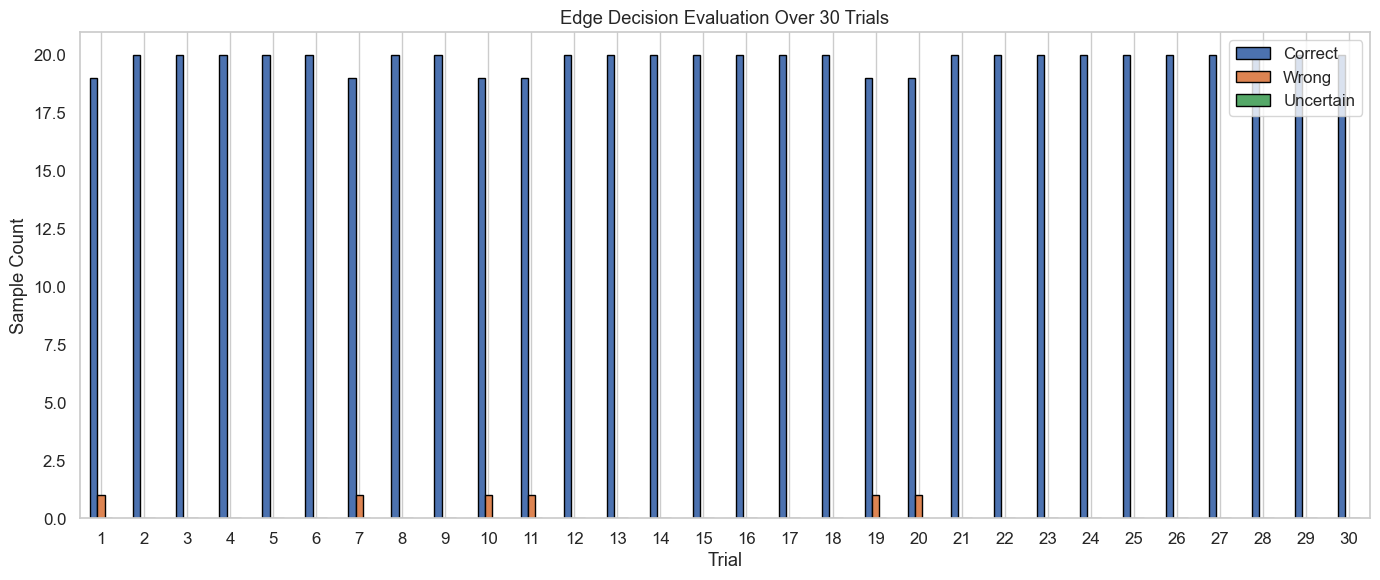

In [285]:

results_df = pd.DataFrame(results)

results_df.set_index("Trial")[["Correct", "Wrong", "Uncertain"]].plot(
    kind="bar", figsize=(14, 6), edgecolor="black"
)
plt.ylabel("Sample Count")
plt.title("Edge Decision Evaluation Over 30 Trials")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [288]:
avg_correct = results_df["Correct"].mean()
avg_wrong = results_df["Wrong"].mean()
avg_uncertain = results_df["Uncertain"].mean()

print(f"Avg Correct: {avg_correct:.2f}")
print(f"Avg Wrong: {avg_wrong:.2f}")
print(f"Avg Uncertain: {avg_uncertain:.2f}")

Avg Correct: 19.80
Avg Wrong: 0.20
Avg Uncertain: 0.00


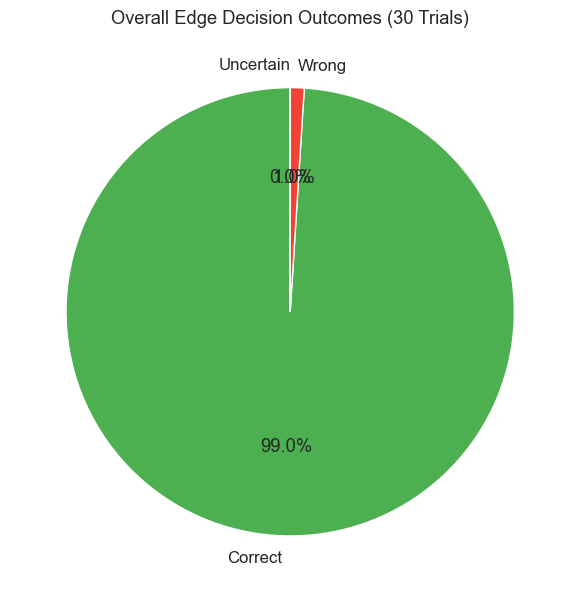

In [289]:

# Aggregate totals
total_counts = results_df[["Correct", "Wrong", "Uncertain"]].sum()

# Pie chart
plt.figure(figsize=(6, 9))
plt.pie(total_counts, labels=total_counts.index, autopct="%1.1f%%", startangle=90, colors=["#4CAF50", "#F44336", "#FFC107"])
plt.title("Overall Edge Decision Outcomes (30 Trials)")
plt.tight_layout()
plt.show()

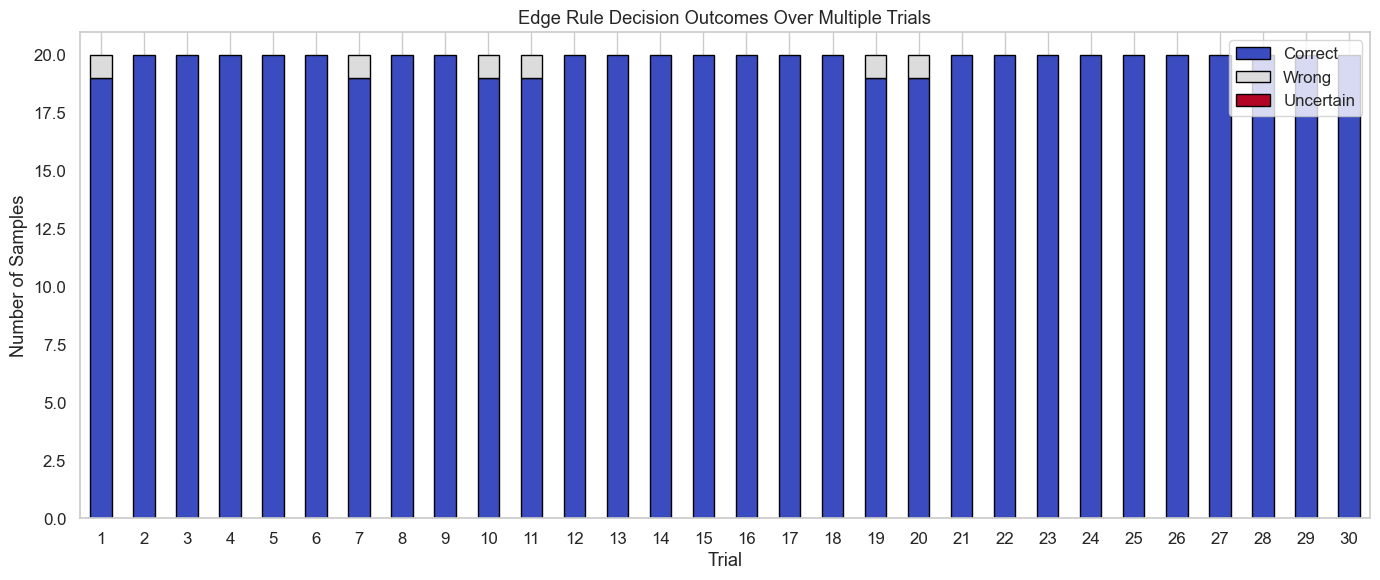

In [290]:
results_df.set_index("Trial")[["Correct", "Wrong", "Uncertain"]].plot(
    kind="bar", stacked=True, figsize=(14, 6), colormap="coolwarm", edgecolor="black"
)
plt.title("Edge Rule Decision Outcomes Over Multiple Trials")
plt.ylabel("Number of Samples")
plt.xlabel("Trial")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

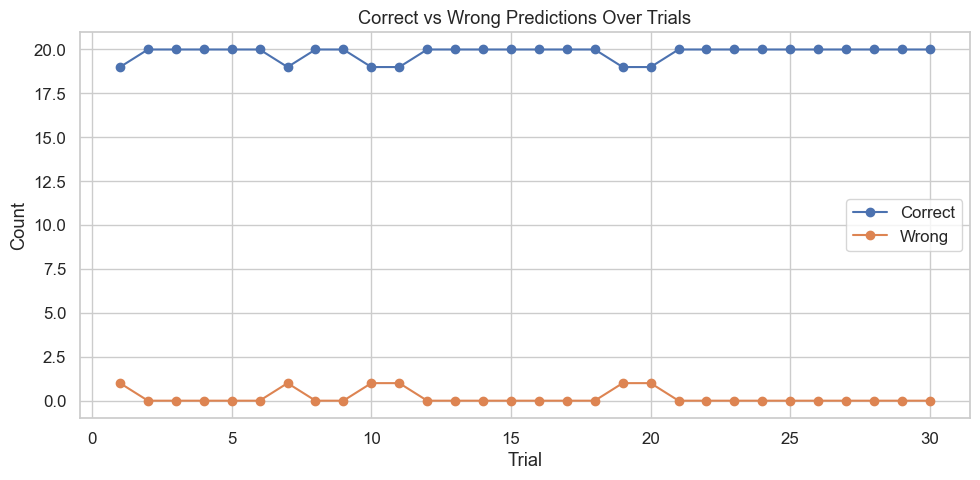

In [291]:
results_df.plot(x="Trial", y=["Correct", "Wrong"], kind="line", marker="o", figsize=(10, 5))
plt.title("Correct vs Wrong Predictions Over Trials")
plt.xlabel("Trial")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

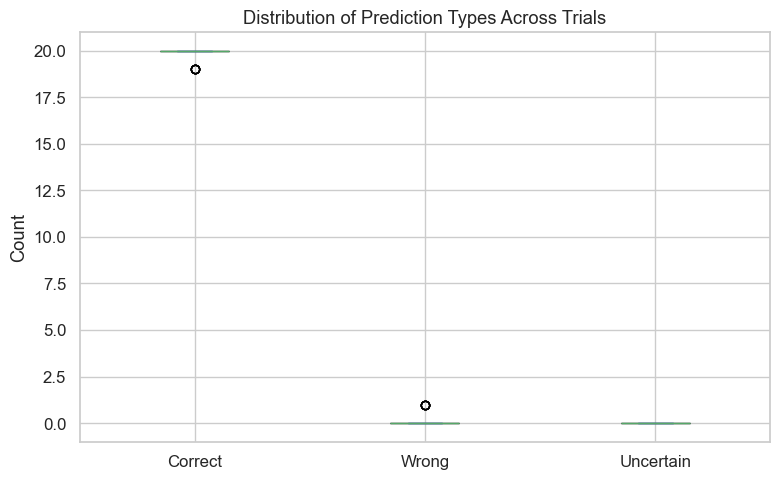

In [292]:
results_df[["Correct", "Wrong", "Uncertain"]].plot.box(figsize=(8, 5), patch_artist=True, boxprops=dict(facecolor="#E0E0E0"))
plt.title("Distribution of Prediction Types Across Trials")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()